# 1. Data Augmentation

## 1.1 Set up

In [1]:
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

In [2]:
device = torch.device("mps")

In [6]:
DATASET = "CIFAR10" #(3,32,32) shape
BATCH_SIZE = 128
DATA_ROOT = "./data"
NUM_WORKERS = 2

## 1.2 baseline transform and aug transform

In [7]:
mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
aug_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), #mirror, flip horizontally with 50% prob
    transforms.RandomCrop(32, padding=4), #padding 4 to get 40*40, then crop to 32*32
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #factor is [0.8, 1.2] to adjust brightness contrast and saturation
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

base_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## 1.3 training data has aug and base version

In [10]:
train_base = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform=base_tfms)
train_aug = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform=aug_tfms)
test_set = datasets.CIFAR10(DATA_ROOT, train=False, download=False, transform=base_tfms)

train_loader_base = DataLoader(train_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
train_loader_aug = DataLoader(train_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


# 2. BN NumPy

## 2.1 BN1d

In [19]:
class BatchNorm1dScratch:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.gamma = np.ones((1, num_features), dtype=np.float32)
        self.beta = np.zeros((1, num_features), dtype=np.float32)

        self.running_mean = np.zeros((1, num_features), dtype=np.float32)
        self.running_var = np.ones((1, num_features), dtype=np.float32)

        self.cache = None
        self.training = True

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def forward(self, x):
        if self.training:
            batch_mean = x.mean(axis=0, keepdims=True)
            batch_var = x.var(axis=0, keepdims=True)

            x_hat = (x - batch_mean) / np.sqrt(batch_var + self.eps)
            y = self.gamma * x_hat + self.beta

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * self.running_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * self.running_var

            self.cache = (x, x_hat, batch_mean, batch_var)
            return y
        else:
            x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            y = self.gamma * x_hat + self.beta
            return y

    def backward(self, dy):
        assert self.cache is not None, "Must call forward in training before backward"
        x, x_hat, mean, var = self.cache
        N = x.shape[0]

        dbeta = dy.sum(axis=0, keepdims=True)
        dgamma = (dy * x_hat).sum(axis=0, keepdims=True)

        dx_hat = dy * self.gamma

        dvar = (dx_hat * (x - mean) * -0.5 * (var + self.eps) ** (-1.5)).sum(axis=0, keepdims=True)
        #above is simple, maybe a little bit chain rule,
        #below two derivatives, mean is also var=1/N sigma(xi-mean)**2
        #and x through mean x through var
        dmean = (dx_hat * -1 / np.sqrt(var + self.eps)).sum(axis=0, keepdims=True) + dvar * (-2 * (x - mean)).mean(axis=0, keepdims=True)
        dx = dx_hat * 1 / np.sqrt(var + self.eps) + dvar * x * (x - mean) / N + dmean / N
        return dx, dgamma, dbeta

## 2.2 Gradient check 1d

In [28]:
def num_grad_check_1d():
    np.random.seed(42)
    N, C = 4, 3
    bn = BatchNorm1dScratch(C)
    bn.train()

    x = np.random.randn(N, C).astype(np.float32)
    y = bn.forward(x)
    loss = (y ** 2).sum() / 2.0
    dy = y

    dx, dgamma, dbeta = bn.backward(dy)

    eps = 1e-3

    g_num = np.zeros_like(bn.gamma)
    for i in range(C):
        old = bn.gamma[0, i]
        bn.gamma[0, i] = old + eps
        y1 = bn.forward(x)
        l1 = (y1 ** 2).sum() / 2.0
        bn.gamma[0, i] = old - eps
        y2 = bn.forward(x)
        l2 = (y2 ** 2).sum() / 2.0
        g_num[0, i] = (l1 - l2) / (2 * eps)
        bn.gamma[0, i] = old
        bn.forward(x)

    b_num = np.zeros_like(bn.beta)
    for i in range(C):
        old = bn.beta[0, i]
        bn.beta[0, i] = old + eps
        y1 = bn.forward(x)
        l1 = (y1 ** 2).sum() / 2.0
        bn.beta[0, i] = old - eps
        y2 = bn.forward(x)
        l2 = (y2 ** 2).sum() / 2.0
        b_num[0, i] = (l1 - l2) / (2 * eps)
        bn.beta[0, i] = old
        bn.forward(x)
    print(f"dgamma max diff: {np.abs(dgamma - g_num).max()}")
    print(f"dbeta max diff: {np.abs(dbeta - b_num).max()}")

In [29]:
num_grad_check_1d()

dgamma max diff: 0.0003764629364013672
dbeta max diff: 0.00023853778839111328


## 2.3 BN2d

In [30]:
class BatchNorm2dScratch:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.gamma = np.ones((1, num_features, 1, 1), dtype=np.float32)
        self.beta = np.zeros((1, num_features, 1, 1), dtype=np.float32)

        self.running_mean = np.zeros((1, num_features, 1, 1), dtype=np.float32)
        self.running_var = np.ones((1, num_features, 1, 1), dtype=np.float32)

        self.cache = None
        self.training = True

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def forward(self, x):
        """
        x: N C H W
        """
        if self.training:
            #for N, H, W, every channel calculate
            N, C, H, W = x.shape
            x_reshaped = x.tarnspose(1, 0, 2, 3).reshape(C, -1) # C * (N*H*W)
            mean = x_reshaped.mean(axis=1, keepdims=True)[:, None, None] #C * 1 * 1
            var = x_reshaped.var(axis=1, keepdims=True)[:, None, None] #C * 1 * 1

            mean = mean.reshape(1, C, 1, 1)
            var = var.reshape(1, C, 1, 1)
            
            x_hat = (x - men) / np.sqrt(var + self.eps)
            y = self.gamma * x_hat + self.beta

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * self.running_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * self.running_var

            self.cache = (x, x_hat, batch_mean, batch_var)
            return y
        else:
            x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            y = self.gamma * x_hat + self.beta
            return y

    def backward(self, dy):
        """
        dy: (N, C, H, W)
        returns: dx, dgamma, dbeta
        """
        assert self.cache is not None, "Must call forward in training before backward"
        x, x_hat, mean, var = self.cache
        N, C, H, W = x.shape
        M = N * H * W

        dbeta = dy.sum(axis=(0, 2, 3), keepdims=True)
        dgamma = (dy * x_hat).sum(axis=(0, 2, 3), keepdims=True)

        dx_hat = dy * self.gamma
        inv_std = 1.0 / np.sqrt(var + self.eps)

        dvar = (dx_hat * (x - mean) * -0.5 * (inv_std**3)).sum(axis=(0,2,3), keepdims=True)
        dmean = (dx_hat * -inv_std).sum(axis=(0,2,3), keepdims=True) + dvar * (-2 * (x - mean)).sum(axis=(0,2,3), keepdims=True) / M
        dx = dx_hat * inv_std + dvar * 2 * (x - mean) / M + dmean / M
        return dx, dgamma, dbeta

# 3. Pytorch: BN, no BN, BN + Aug

## 3.1 Define a CNN, support BN or not BN

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes, use_bn=True, in_channels=1):
        super().__init__()
        self.use_bn = use_bn

        def conv_block(cin, cout):
            if use_bn:
                return nn.Sequential(
                    nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(cout),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2)
                )
            else:
                return nn.Sequential(
                    nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=True),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2)
                )

        self.enc = nn.Sequential(
            conv_block(in_channels, 32),
            conv_block(32, 64),
        )

        feat_hw = 8
        in_channels = 3
        num_classes = 10

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * feat_hw * feat_hw, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.head(x)
        return x

## 3.2 Train

In [35]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct, total_cnt = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_cnt += x.size(0)
    return total_loss / total_cnt, total_correct / total_cnt

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total_cnt = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_cnt += x.size(0)
    return total_loss / total_cnt, total_correct / total_cnt

## 3.3 Run BN/no BN/BN + Aug

In [36]:
import copy
import time

def run_experiment(train_loader, tag, use_bn=True, epochs=5, lr=1e-3):
    in_ch, num_classes = 3, 10

    model = SmallCNN(num_classes=num_classes, use_bn=use_bn, in_channels=in_ch).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
    t0 = time.time()
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        te_loss, te_acc = evaluate(model, test_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)
        print(f"[{tag}] epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | test {te_loss:.4f}/{te_acc:.4f}")
    t1 = time.time()
    print(f"[{tag}] done in {t1 - t0:.1f}s")
    return model, history

EPOCHS = 15

model_s1, hist_s1 = run_experiment(train_loader_base, tag="S1_noBN_base", use_bn=False, epochs=EPOCHS, lr=1e-3)
model_s2, hist_s2 = run_experiment(train_loader_base, tag="S2_BN_base",   use_bn=True,  epochs=EPOCHS, lr=1e-3)
model_s3, hist_s3 = run_experiment(train_loader_aug,  tag="S3_BN_aug",    use_bn=True,  epochs=EPOCHS, lr=1e-3)

[S1_noBN_base] epoch 01 | train 1.3633/0.5160 | test 1.1039/0.6180
[S1_noBN_base] epoch 02 | train 0.9907/0.6528 | test 0.9639/0.6615
[S1_noBN_base] epoch 03 | train 0.8448/0.7035 | test 0.9087/0.6843
[S1_noBN_base] epoch 04 | train 0.7319/0.7430 | test 0.8723/0.6966
[S1_noBN_base] epoch 05 | train 0.6390/0.7759 | test 0.8461/0.7120
[S1_noBN_base] epoch 06 | train 0.5540/0.8057 | test 0.8411/0.7197
[S1_noBN_base] epoch 07 | train 0.4677/0.8369 | test 0.8892/0.7131
[S1_noBN_base] epoch 08 | train 0.3918/0.8645 | test 0.9411/0.7182
[S1_noBN_base] epoch 09 | train 0.3241/0.8879 | test 1.0033/0.7169
[S1_noBN_base] epoch 10 | train 0.2558/0.9132 | test 1.0444/0.7184
[S1_noBN_base] epoch 11 | train 0.2047/0.9290 | test 1.1400/0.7153
[S1_noBN_base] epoch 12 | train 0.1584/0.9456 | test 1.2184/0.7163
[S1_noBN_base] epoch 13 | train 0.1243/0.9584 | test 1.3567/0.7101
[S1_noBN_base] epoch 14 | train 0.1036/0.9656 | test 1.4602/0.7046
[S1_noBN_base] epoch 15 | train 0.1024/0.9645 | test 1.5356/0.

## 3.4 Plot the loss comparison

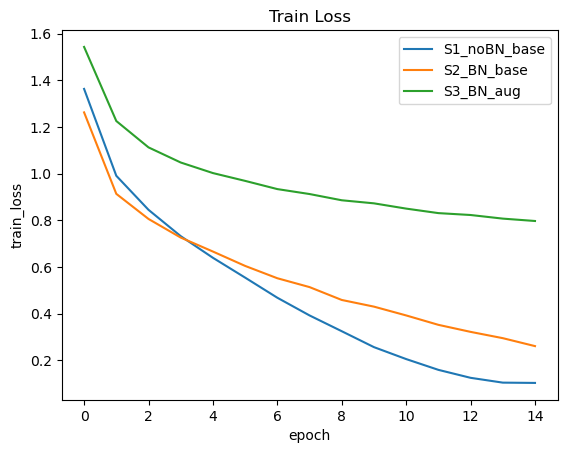

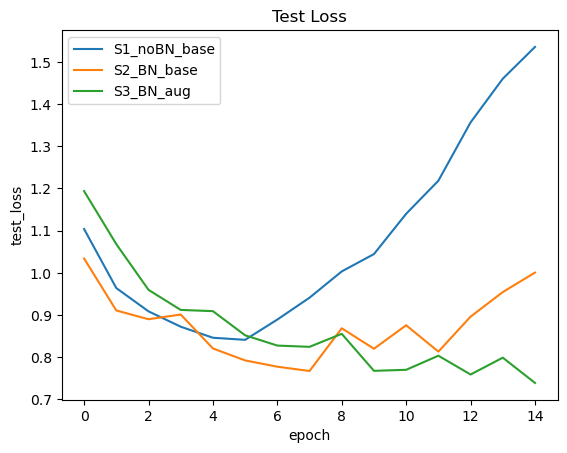

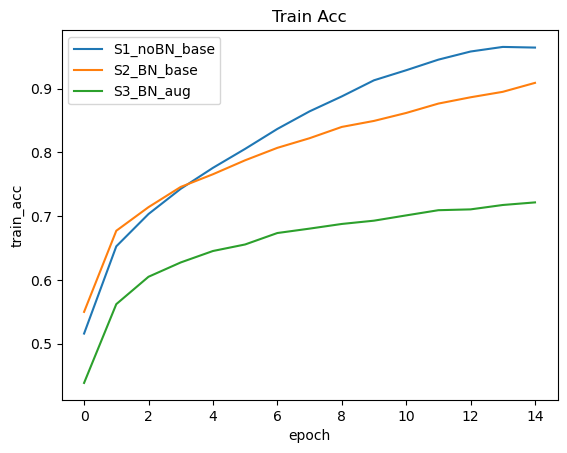

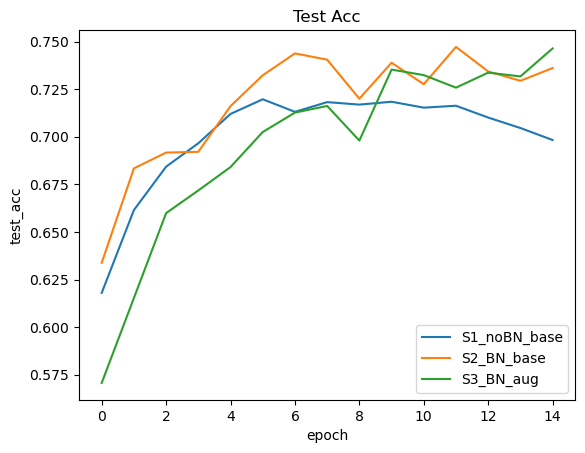

In [37]:
import matplotlib.pyplot as plt

def plot_metric(h1, h2, h3, key, title):
    plt.figure()
    plt.plot(h1[key], label="S1_noBN_base")
    plt.plot(h2[key], label="S2_BN_base")
    plt.plot(h3[key], label="S3_BN_aug")
    plt.xlabel("epoch")
    plt.ylabel(key)
    plt.title(title)
    plt.legend()
    plt.show()

plot_metric(hist_s1, hist_s2, hist_s3, "train_loss", "Train Loss")
plot_metric(hist_s1, hist_s2, hist_s3, "test_loss",  "Test Loss")
plot_metric(hist_s1, hist_s2, hist_s3, "train_acc",  "Train Acc")
plot_metric(hist_s1, hist_s2, hist_s3, "test_acc",   "Test Acc")

# 4. BN using Pytorch so can directly use in CNN (all code from GPT)

In [39]:
import torch
import torch.nn as nn

class BatchNorm1dScratchTorch(nn.Module):
    """
    PyTorch 版手写 BN1d：
    - 支持输入形状 (N, C) 或 (N, C, L)（会在 dim=0 和后续空间维度上做统计）
    - unbiased=False，与你 NumPy 推导一致（除以 N）
    - 训练：用 batch 统计；推理：用 running 统计
    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))
            self.beta  = nn.Parameter(torch.zeros(num_features))
        else:
            self.register_parameter("gamma", None)
            self.register_parameter("beta",  None)

        if self.track_running_stats:
            self.register_buffer("running_mean", torch.zeros(num_features))
            self.register_buffer("running_var",  torch.ones(num_features))
        else:
            self.register_buffer("running_mean", None)
            self.register_buffer("running_var",  None)

    def _reduce_dims(self, x):
        # 支持 (N, C) 或 (N, C, L, ...)
        # 统计维度：batch 维 + 所有空间维（除了通道 C）
        dims = list(range(x.dim()))
        assert x.dim() >= 2, "Expect input as (N, C, ...) with at least 2 dims"
        reduce_dims = [0] + list(range(2, x.dim()))
        return reduce_dims

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 广播用到的 reshape（将 (C,) 变为 (1,C,1,1,...)）
        shape = [1, self.num_features] + [1] * (x.dim() - 2)

        if self.training:
            reduce_dims = self._reduce_dims(x)
            mean = x.mean(dim=reduce_dims, keepdim=False)                    # (C,)
            var  = x.var(dim=reduce_dims, keepdim=False, unbiased=False)     # (C,)

            # 标准化
            x_hat = (x - mean.view(shape)) / torch.sqrt(var.view(shape) + self.eps)

            # 仿射
            if self.affine:
                y = self.gamma.view(shape) * x_hat + self.beta.view(shape)
            else:
                y = x_hat

            # 更新 running 统计量
            if self.track_running_stats:
                # 保持与你 NumPy 版一致的更新公式
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.detach()
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * var.detach()

            return y
        else:
            assert self.track_running_stats and self.running_mean is not None, \
                "Eval 模式需使用 running_mean/var，请在训练中先估计或启用 track_running_stats。"
            x_hat = (x - self.running_mean.view(shape)) / torch.sqrt(self.running_var.view(shape) + self.eps)
            if self.affine:
                y = self.gamma.view(shape) * x_hat + self.beta.view(shape)
            else:
                y = x_hat
            return y


class BatchNorm2dScratchTorch(nn.Module):
    """
    PyTorch 版手写 BN2d：
    - 期望输入形状 (N, C, H, W)
    - unbiased=False，与手推一致
    - 训练：batch 统计；推理：running 统计
    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))
            self.beta  = nn.Parameter(torch.zeros(num_features))
        else:
            self.register_parameter("gamma", None)
            self.register_parameter("beta",  None)

        if self.track_running_stats:
            self.register_buffer("running_mean", torch.zeros(num_features))
            self.register_buffer("running_var",  torch.ones(num_features))
        else:
            self.register_buffer("running_mean", None)
            self.register_buffer("running_var",  None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.dim() == 4, "BN2d 期望输入 (N, C, H, W)"
        N, C, H, W = x.shape
        shape = (1, C, 1, 1)

        if self.training:
            # 按通道统计 (N, H, W) 的均值与方差
            mean = x.mean(dim=(0, 2, 3))                                 # (C,)
            var  = x.var(dim=(0, 2, 3), unbiased=False)                  # (C,)

            x_hat = (x - mean.view(shape)) / torch.sqrt(var.view(shape) + self.eps)

            if self.affine:
                y = self.gamma.view(shape) * x_hat + self.beta.view(shape)
            else:
                y = x_hat

            if self.track_running_stats:
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.detach()
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * var.detach()

            return y
        else:
            assert self.track_running_stats and self.running_mean is not None, \
                "Eval 模式需使用 running_mean/var，请在训练中先估计或启用 track_running_stats。"
            x_hat = (x - self.running_mean.view(shape)) / torch.sqrt(self.running_var.view(shape) + self.eps)
            if self.affine:
                y = self.gamma.view(shape) * x_hat + self.beta.view(shape)
            else:
                y = x_hat
            return y


In [40]:
def replace_bn2d_with_scratch(module: nn.Module):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.BatchNorm2d):
            new_bn = BatchNorm2dScratchTorch(
                num_features=child.num_features,
                eps=child.eps,
                momentum=child.momentum,
                affine=child.affine,
                track_running_stats=True,  # 与原生 BN 一致
            )
            # 尝试把原有参数拷贝到自定义版本（方便无缝切换继续训练/推理）
            if child.affine:
                with torch.no_grad():
                    new_bn.gamma.copy_(child.weight.data)
                    new_bn.beta.copy_(child.bias.data)
            with torch.no_grad():
                new_bn.running_mean.copy_(child.running_mean.data)
                new_bn.running_var.copy_(child.running_var.data)
            setattr(module, name, new_bn)
        else:
            replace_bn2d_with_scratch(child)


In [41]:
model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
)

# 一键替换
replace_bn2d_with_scratch(model)
print(model)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2dScratchTorch()
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2dScratchTorch()
  (5): ReLU()
)


In [42]:
def sanity_check_bn2d():
    torch.manual_seed(0)
    x = torch.randn(8, 16, 7, 7)

    bn_ref = nn.BatchNorm2d(16, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
    bn_ref.train()
    y_ref = bn_ref(x)

    bn_my = BatchNorm2dScratchTorch(16, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
    bn_my.train()
    # 拷贝参数，以避免初值差异
    with torch.no_grad():
        bn_my.gamma.copy_(bn_ref.weight.data)
        bn_my.beta.copy_(bn_ref.bias.data)
    y_my = bn_my(x)

    print("train mode diff:", (y_ref - y_my).abs().mean().item())

    # 切换 eval（使用 running 统计量）
    bn_ref.eval()
    bn_my.eval()
    x2 = torch.randn(8, 16, 7, 7)
    y_ref2 = bn_ref(x2)
    y_my2  = bn_my(x2)
    print("eval mode diff:", (y_ref2 - y_my2).abs().mean().item())

sanity_check_bn2d()


train mode diff: 3.9602277013273124e-08
eval mode diff: 0.00010282390576321632


In [43]:
import torch
import torch.nn as nn

# 需要：先定义好 BatchNorm2dScratchTorch（见上一条消息中的实现）
# from your_module import BatchNorm2dScratchTorch

class SmallCNN(nn.Module):
    """
    一个简洁的小型 CNN，支持：
      - use_bn=False: 不使用 BN
      - use_bn=True, use_native_bn=True: 使用 nn.BatchNorm2d
      - use_bn=True, use_native_bn=False: 使用 BatchNorm2dScratchTorch（手写版）
    通过 input_size 自动计算全连接层输入维度，适配不同数据集。
    """
    def __init__(
        self,
        in_channels: int,
        num_classes: int = 10,
        use_bn: bool = True,
        use_native_bn: bool = True,
        input_size=(32, 32),          # (H, W)，CIFAR-10: (32,32)；MNIST: (28,28)
        hidden_dim: int = 128,
        channels=(32, 64),            # 两个卷积块的通道数
        eps: float = 1e-5,
        momentum: float = 0.1
    ):
        super().__init__()
        self.use_bn = use_bn
        self.use_native_bn = use_native_bn
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.channels = channels
        self.eps = eps
        self.momentum = momentum

        # 选择 BN 类
        if self.use_bn:
            if self.use_native_bn:
                BN = lambda c: nn.BatchNorm2d(c, eps=self.eps, momentum=self.momentum, affine=True, track_running_stats=True)
            else:
                BN = lambda c: BatchNorm2dScratchTorch(c, eps=self.eps, momentum=self.momentum, affine=True, track_running_stats=True)
        else:
            BN = None

        def conv_block(cin, cout):
            layers = [nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=not self.use_bn)]
            if self.use_bn:
                layers.append(BN(cout))
            layers += [nn.ReLU(inplace=True), nn.MaxPool2d(2)]
            return nn.Sequential(*layers)

        c1, c2 = self.channels
        self.enc = nn.Sequential(
            conv_block(self.in_channels, c1),
            conv_block(c1, c2),
        )

        # 动态计算 flatten 维度
        with torch.no_grad():
            dummy = torch.zeros(1, self.in_channels, self.input_size[0], self.input_size[1])
            feat = self.enc(dummy)
            flat_dim = feat.shape[1] * feat.shape[2] * feat.shape[3]

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, self.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_dim, self.num_classes),
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.head(x)
        return x


In [44]:
# CIFAR-10（RGB）
model_native_bn = SmallCNN(in_channels=3, num_classes=10, use_bn=True, use_native_bn=True, input_size=(32,32))
model_scratch_bn = SmallCNN(in_channels=3, num_classes=10, use_bn=True, use_native_bn=False, input_size=(32,32))
model_no_bn = SmallCNN(in_channels=3, num_classes=10, use_bn=False, input_size=(32,32))

# MNIST（灰度）
model_mnist_native_bn = SmallCNN(in_channels=1, num_classes=10, use_bn=True, use_native_bn=True, input_size=(28,28))


In [45]:
import torch, random, numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def infer_input_size_from_loader(loader):
    # 从一个 batch 里读出 H, W；输入应为 (N, C, H, W)
    for x, _ in loader:
        return x.shape[-2], x.shape[-1]
    raise ValueError("Empty loader; cannot infer input size")

In [46]:
def run_experiment_once(
    train_loader,
    test_loader,
    tag,
    in_channels,
    num_classes=10,
    use_bn=True,
    use_native_bn=True,
    input_size=(32,32),
    epochs=10,
    lr=1e-3,
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SmallCNN(
        in_channels=in_channels,
        num_classes=num_classes,
        use_bn=use_bn,
        use_native_bn=use_native_bn,
        input_size=input_size,
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    hist = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        te_loss, te_acc = evaluate(model, test_loader, criterion)

        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["test_loss"].append(te_loss)
        hist["test_acc"].append(te_acc)

        print(f"[{tag}] epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | test {te_loss:.4f}/{te_acc:.4f}")

    return model, hist


In [47]:
import matplotlib.pyplot as plt

def run_experiments_3tracks(
    train_loader_base,
    train_loader_aug,
    test_loader,
    dataset="CIFAR10",     # 或 "MNIST"
    epochs=10,
    lr=1e-3,
    seed=42,
):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 推断输入形状(H, W) & 通道数
    H, W = infer_input_size_from_loader(train_loader_base)
    for x, _ in train_loader_base:
        in_channels = x.shape[1]
        break
    num_classes = 10

    input_size = (H, W)

    # S1: 无 BN + 无增强
    m1, h1 = run_experiment_once(
        train_loader=train_loader_base,
        test_loader=test_loader,
        tag="S1_noBN_base",
        in_channels=in_channels,
        num_classes=num_classes,
        use_bn=False,
        use_native_bn=True,      # 无意义，占位
        input_size=input_size,
        epochs=epochs,
        lr=lr,
        device=device,
    )

    # S2: 原生 BN + 无增强
    m2, h2 = run_experiment_once(
        train_loader=train_loader_base,
        test_loader=test_loader,
        tag="S2_BN_native_base",
        in_channels=in_channels,
        num_classes=num_classes,
        use_bn=True,
        use_native_bn=True,      # 使用 nn.BatchNorm2d
        input_size=input_size,
        epochs=epochs,
        lr=lr,
        device=device,
    )

    # S3: 手写 BN + 增强
    m3, h3 = run_experiment_once(
        train_loader=train_loader_aug,
        test_loader=test_loader,
        tag="S3_BN_scratch_aug",
        in_channels=in_channels,
        num_classes=num_classes,
        use_bn=True,
        use_native_bn=False,     # 使用 BatchNorm2dScratchTorch
        input_size=input_size,
        epochs=epochs,
        lr=lr,
        device=device,
    )

    # 画三条曲线
    def plot_key(key, title):
        plt.figure()
        plt.plot(h1[key], label="S1_noBN_base")
        plt.plot(h2[key], label="S2_BN_native_base")
        plt.plot(h3[key], label="S3_BN_scratch_aug")
        plt.xlabel("epoch")
        plt.ylabel(key)
        plt.title(f"{title} ({dataset})")
        plt.legend()
        plt.show()

    plot_key("train_loss", "Train Loss")
    plot_key("test_loss",  "Test Loss")
    plot_key("train_acc",  "Train Accuracy")
    plot_key("test_acc",   "Test Accuracy")

    return {
        "S1": {"model": m1, "hist": h1},
        "S2": {"model": m2, "hist": h2},
        "S3": {"model": m3, "hist": h3},
    }


In [48]:
import matplotlib.pyplot as plt

def run_experiments_3tracks(
    train_loader_base,
    train_loader_aug,
    test_loader,
    dataset="CIFAR10",     # 或 "MNIST"
    epochs=10,
    lr=1e-3,
    seed=42,
):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 推断输入形状(H, W) & 通道数
    H, W = infer_input_size_from_loader(train_loader_base)
    for x, _ in train_loader_base:
        in_channels = x.shape[1]
        break
    num_classes = 10

    input_size = (H, W)

    # S1: 无 BN + 无增强
    m1, h1 = run_experiment_once(
        train_loader=train_loader_base,
        test_loader=test_loader,
        tag="S1_noBN_base",
        in_channels=in_channels,
        num_classes=num_classes,
        use_bn=False,
        use_native_bn=True,      # 无意义，占位
        input_size=input_size,
        epochs=epochs,
        lr=lr,
        device=device,
    )

    # S2: 原生 BN + 无增强
    m2, h2 = run_experiment_once(
        train_loader=train_loader_base,
        test_loader=test_loader,
        tag="S2_BN_native_base",
        in_channels=in_channels,
        num_classes=num_classes,
        use_bn=True,
        use_native_bn=True,      # 使用 nn.BatchNorm2d
        input_size=input_size,
        epochs=epochs,
        lr=lr,
        device=device,
    )

    # S3: 手写 BN + 增强
    m3, h3 = run_experiment_once(
        train_loader=train_loader_aug,
        test_loader=test_loader,
        tag="S3_BN_scratch_aug",
        in_channels=in_channels,
        num_classes=num_classes,
        use_bn=True,
        use_native_bn=False,     # 使用 BatchNorm2dScratchTorch
        input_size=input_size,
        epochs=epochs,
        lr=lr,
        device=device,
    )

    # 画三条曲线
    def plot_key(key, title):
        plt.figure()
        plt.plot(h1[key], label="S1_noBN_base")
        plt.plot(h2[key], label="S2_BN_native_base")
        plt.plot(h3[key], label="S3_BN_scratch_aug")
        plt.xlabel("epoch")
        plt.ylabel(key)
        plt.title(f"{title} ({dataset})")
        plt.legend()
        plt.show()

    plot_key("train_loss", "Train Loss")
    plot_key("test_loss",  "Test Loss")
    plot_key("train_acc",  "Train Accuracy")
    plot_key("test_acc",   "Test Accuracy")

    return {
        "S1": {"model": m1, "hist": h1},
        "S2": {"model": m2, "hist": h2},
        "S3": {"model": m3, "hist": h3},
    }


In [ ]:
results = run_experiments_3tracks(
    train_loader_base=train_loader_base,
    train_loader_aug=train_loader_aug,
    test_loader=test_loader,
    dataset="CIFAR10",    # 或 "MNIST"
    epochs=8,             # 自行调整
    lr=1e-3,
    seed=42,
)